# LSTM Training
This notebook trains an LSTM model for our data and saves it.

In [2]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score 

# Discretising the data
To reduce the computational load of the problem, we have only taken data at every 1% strain step instead of all timesteps for which the FE Simulation runs. The snippet below input the data file and looks for timesteps with 1% increment in applied strain and stores them. 

- `out_file["eff_strain"]` - contains all values of applied strain at every timestep, we look for timesteps at which there is 1\% increment in strain and record them. 
- `df` - contains all the data as read from the FE output file.
- `df_steps` - contains the data only at 1\% strain steps 
- `df_steps_norm` - contains the normalised data only at 1\% strain steps

In [3]:
out_file = pd.read_csv('data/AR1/out.csv')
lim = 0.01
timesteps = []
time = []
for i in range(len(out_file)):
    if(out_file["eff_strain"][i] > lim):
        timesteps.append(i+1)
        time.append(out_file["time"][i])
        lim = lim + 0.01
steps = np.ceil((np.array(timesteps)/50))

# Reading data
df = pd.read_csv('data/AR1/out_soudip.csv')
df_dropped = df.drop(columns=['sdv22', 'sdv23', 'total_strain_xy', 'elem_id', 'blk_id'])
df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())

df_steps = df_dropped[df_dropped["time"].isin(steps)]
df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
df_group = df_steps_norm.groupby(["elem_x", "elem_y"])

# Creating a directory
A directory with a unique model number is defined where the model and all the results are saved. 

In [4]:
model_number = 37 # soudip data 0 to 1 with bias
base_path = './trained_models/lstm_model_%i' % (model_number)
os.mkdir(base_path)

# Structuring Data
As LSTM is used for sequence prediction. Even though the data we have is 2D spatio temporal data, it can be restructured to be a simple sequence prediction problem, where we have 3 different variables and 16,000 elements. Each variable and element's value evolves over time, giving us a total of 16,000\*3 = 48,000 sequences. We have taken data for 15 timesteps, (0, 0.01\%, ...0.15\% strains), hence each sequences is of the length 15. Below, the data is arranged in to sequences and prepared for training. The data has the shape 48,000\*15. 

`raw` - contains the sequences 

In [5]:
raw = pd.DataFrame()
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_strain' % name
    val = group['eff_strain'].values
    raw[col] = val
print("Effective strain done")
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_stress' % name
    val = group['vonmises'].values
    raw[col] = val
print("Vonmises done")
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_triaxiality' % name
    val = group['triaxiality'].values
    raw[col] = val
print("Strain triaxiality done")


Effective strain done
Vonmises done
Strain triaxiality done


# Preparing data for supervised learning
Supervised learning, as the name indicates, has the presence of a supervisor as a teacher. Basically supervised learning is when we teach or train the machine using data that is well labeled. Our model is designed such that it takes the input for all the variables for each elements at timestep t and makes a prediction for values at t+1. 
For a given strain step, t, 48,000 length vector X<sub>t</sub> is input to the LSTM model and used to predict the output vector, Y<sub>t</sub> which consists of values at the next strain step in the series X<sub>t</sub>. The structure of the data can be better understood through the table below

| Input | Output |
| :---: | :-----: |
| X<sub>1</sub> | X<sub>2</sub> |
| X<sub>2</sub> | X<sub>3</sub> |
| X<sub>3</sub> | X<sub>4</sub> |
| . | . |
| . | . |
| . | . |
| X<sub>10</sub> | X<sub>11</sub> |

- `train_X`, `train_y`: Out of the total 15 strain steps, 70\% are used for training. 
- `val_X`, `val_y`: The remaining 30\%, used for testing the model's performance on data it hasn't seen before.

In [6]:
def series_to_supervised(sequences, n_steps_in, n_steps_out, dropnan=True):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix: out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
        
n_steps_in, n_steps_out = 1, 1
x, y = series_to_supervised(raw.values, n_steps_in, n_steps_out)
print(x.shape, y.shape)

n = len(x)
train_X, train_y = x[0:int(n*0.7)], y[0:int(n*0.7)]
val_X, val_y = x[int(n*0.7):], y[int(n*0.7):]

(15, 1, 480000) (15, 1, 480000)


# Defining the model
The model along with all the hyperparameters is defined below. In the below example the hyper parameters are as follows:

- Number of layers: 8
- Number of LSTM unit in each layer: 200
- Activation function: `tanh`
- Optimisation function: `adam`
- Loss function: `mse`
- Epochs: 300
- `return_sequences`: is given as `True` because we require he output of the LSTM at each timestep and not just the last one. 
- `history`: stores information about the training process of the model

In [7]:
def get_compiled_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(200, activation='tanh', input_shape=(n_steps_in, train_X.shape[2])))
    model.add(tf.keras.layers.RepeatVector(n_steps_out))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(train_X.shape[2])))
    model.compile(optimizer='adam', loss='mse')
    return model

model = get_compiled_model()
history = model.fit(train_X, train_y, epochs=300, shuffle=False)

Epoch 1/300
1/1 [==============================] - 0s 906us/step - loss: 0.1004
Epoch 2/300
1/1 [==============================] - 0s 677us/step - loss: 0.1002
Epoch 3/300
1/1 [==============================] - 0s 780us/step - loss: 0.1000
Epoch 4/300
1/1 [==============================] - 0s 915us/step - loss: 0.0998
Epoch 5/300
1/1 [==============================] - 0s 850us/step - loss: 0.0996
Epoch 6/300
1/1 [==============================] - 0s 926us/step - loss: 0.0993
Epoch 7/300
1/1 [==============================] - 0s 768us/step - loss: 0.0991
Epoch 8/300
1/1 [==============================] - 0s 791us/step - loss: 0.0988
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0986
Epoch 10/300
1/1 [==============================] - 0s 857us/step - loss: 0.0983
Epoch 11/300
1/1 [==============================] - 0s 855us/step - loss: 0.0980
Epoch 12/300
1/1 [==============================] - 0s 870us/step - loss: 0.0978
Epoch 13/300
1/1 [=====================

1/1 [==============================] - 0s 815us/step - loss: 0.0028
Epoch 103/300
1/1 [==============================] - 0s 818us/step - loss: 0.0034
Epoch 104/300
1/1 [==============================] - 0s 819us/step - loss: 0.0040
Epoch 105/300
1/1 [==============================] - 0s 802us/step - loss: 0.0043
Epoch 106/300
1/1 [==============================] - 0s 878us/step - loss: 0.0045
Epoch 107/300
1/1 [==============================] - 0s 773us/step - loss: 0.0044
Epoch 108/300
1/1 [==============================] - 0s 833us/step - loss: 0.0042
Epoch 109/300
1/1 [==============================] - 0s 729us/step - loss: 0.0038
Epoch 110/300
1/1 [==============================] - 0s 844us/step - loss: 0.0034
Epoch 111/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 112/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 113/300
1/1 [==============================] - 0s 810us/step - loss: 0.0024
Epoch 114/300
1/1 [===============

1/1 [==============================] - 0s 737us/step - loss: 0.0022
Epoch 203/300
1/1 [==============================] - 0s 751us/step - loss: 0.0022
Epoch 204/300
1/1 [==============================] - 0s 773us/step - loss: 0.0022
Epoch 205/300
1/1 [==============================] - 0s 843us/step - loss: 0.0022
Epoch 206/300
1/1 [==============================] - 0s 817us/step - loss: 0.0022
Epoch 207/300
1/1 [==============================] - 0s 776us/step - loss: 0.0022
Epoch 208/300
1/1 [==============================] - 0s 874us/step - loss: 0.0022
Epoch 209/300
1/1 [==============================] - 0s 904us/step - loss: 0.0022
Epoch 210/300
1/1 [==============================] - 0s 868us/step - loss: 0.0022
Epoch 211/300
1/1 [==============================] - 0s 704us/step - loss: 0.0022
Epoch 212/300
1/1 [==============================] - 0s 878us/step - loss: 0.0022
Epoch 213/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 214/300
1/1 [=============

# Training plot
The snippet below plots the evolution of loss with every epoch.

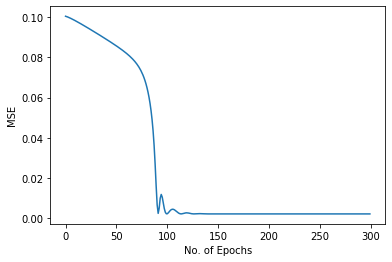

In [8]:
plt.figure()
plt.xlabel("No. of Epochs")
plt.ylabel("MSE")
plt.plot(history.history['loss'], label="MSE (training data)")
plt.savefig(base_path+"/lstm-training_process.eps", format="eps")

# Saving the model
The trained model is saved in the directory created above for future analysis and making predictions. A brief summary of the model architecture is also stored in a text file called `model_summary.txt`. 

In [9]:
model.save(base_path+'/the_model')
with open(base_path + '/model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./trained_models/lstm_model_37/the_model/assets
